In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [182]:
df = pd.read_excel("/content/drive/MyDrive/ML_3/train.xlsx")
df.head(10)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


Сортируем датасет, чтобы лаги были корректными

In [183]:
df = df.sort_values(by='dt').reset_index(drop=True)
df

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


In [184]:
df.shape

(400, 2)

нулевых значений нет

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


# Проверка на стационарность, авторкорреляцию

<Axes: ylabel='Цена на арматуру'>

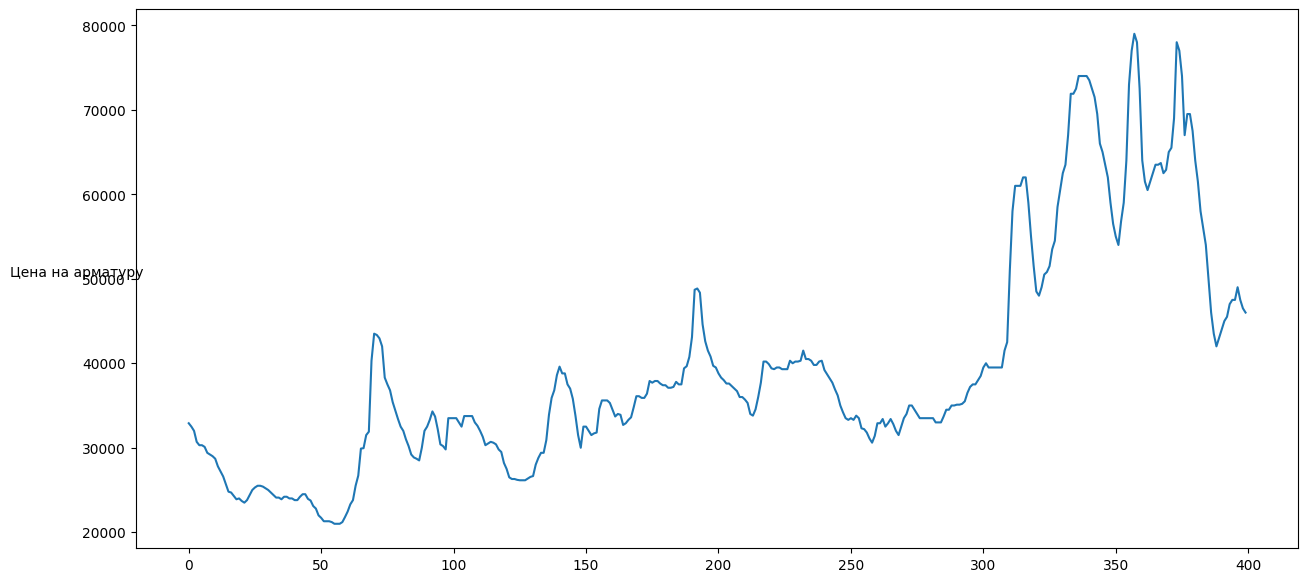

In [186]:
plt.figure(figsize=(15, 7))
plt.ylabel('Цена на арматуру', rotation=0)
df['Цена на арматуру'].plot()

Судя по графику, временной ряд случайный. Однако, можно предположить, что он все таки увеличивается. Чтобы не гадать, можно это проверить

In [187]:
!pip install statsmodels==0.14.4

In [188]:
df["Цена на арматуру"]

,Цена на арматуру
0,32900
1,32500
2,32000
3,30700
4,30300
...,...
395,47500
396,49000
397,47500
398,46500


In [189]:
df.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [190]:
df['Цена на арматуру'].describe()

,Цена на арматуру
count,400.000000
mean,39229.475000
std,13407.979668
min,21000.000000
25%,31075.000000
50%,35450.000000
75%,42000.000000
max,79000.000000


Приводим дату к формату даты и делаем её индексом

In [191]:
df['dt'] = pd.to_datetime(df['dt'], format='%m-%d-%Y')

df = df.set_index(['dt'])

Разложение ряда на компоненты

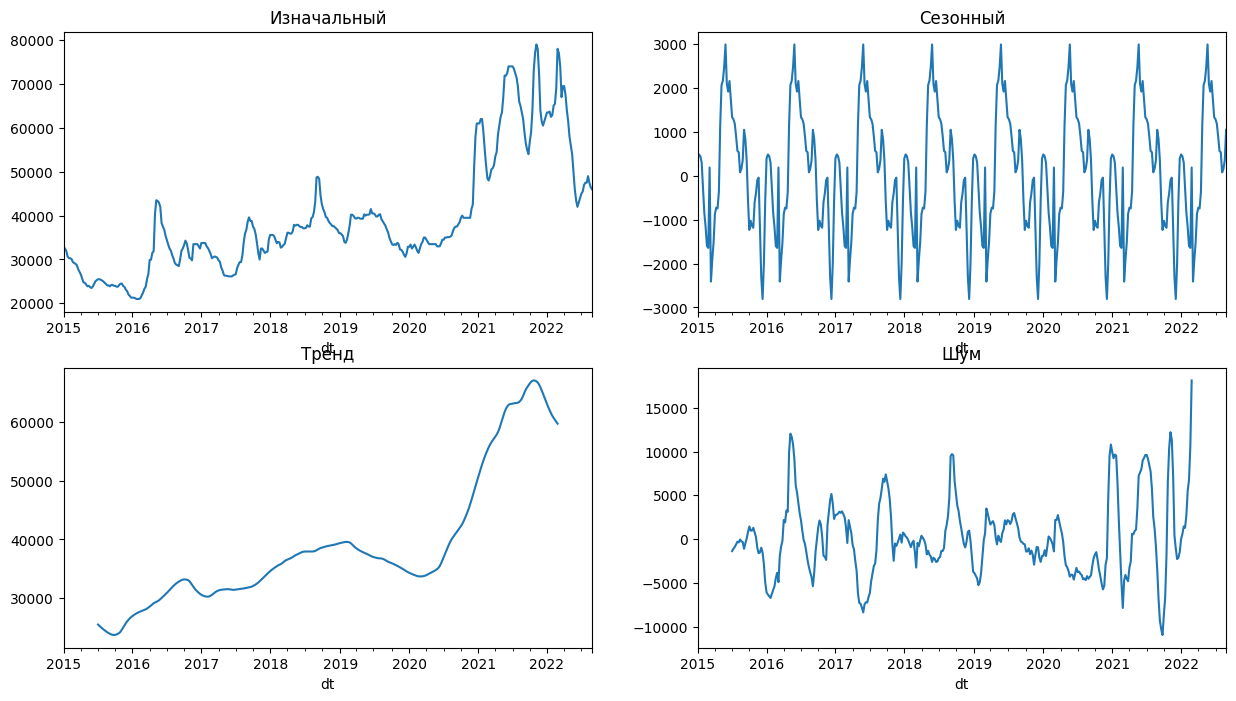

In [192]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

decompose = seasonal_decompose(df[['Цена на арматуру']])

ax[0, 0].set_title('Изначальный')
ax[0, 1].set_title('Сезонный')
ax[1, 0].set_title('Тренд')
ax[1, 1].set_title('Шум')

decompose.observed.plot(ax=ax[0, 0])
decompose.seasonal.plot(ax=ax[0, 1])
decompose.trend.plot(ax=ax[1, 0])
decompose.resid.plot(ax=ax[1, 1]);


Тест на стационарность

In [193]:
from statsmodels.tsa.stattools import adfuller, acf

result = adfuller(df['Цена на арматуру'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155


можно предположить, т.к. p > 0.05, что временной ряд нестационарен
Надо убрать тренд и сезонность

Автокорреляция и частичная автокорреляция

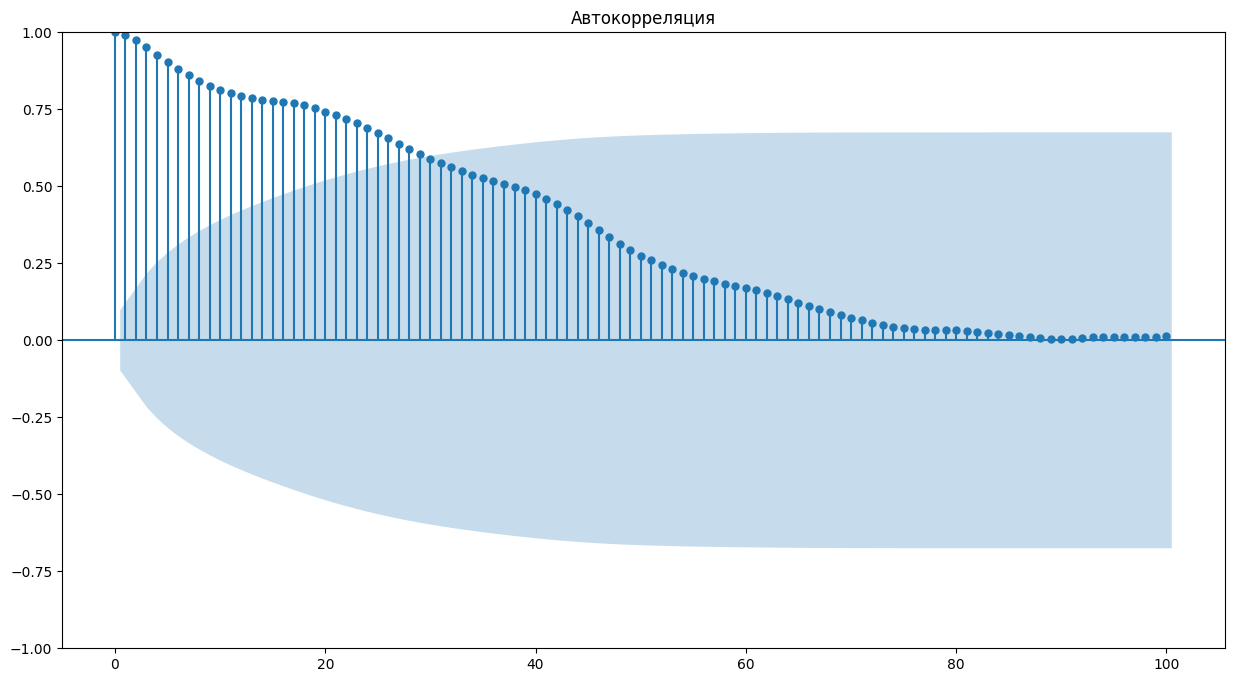

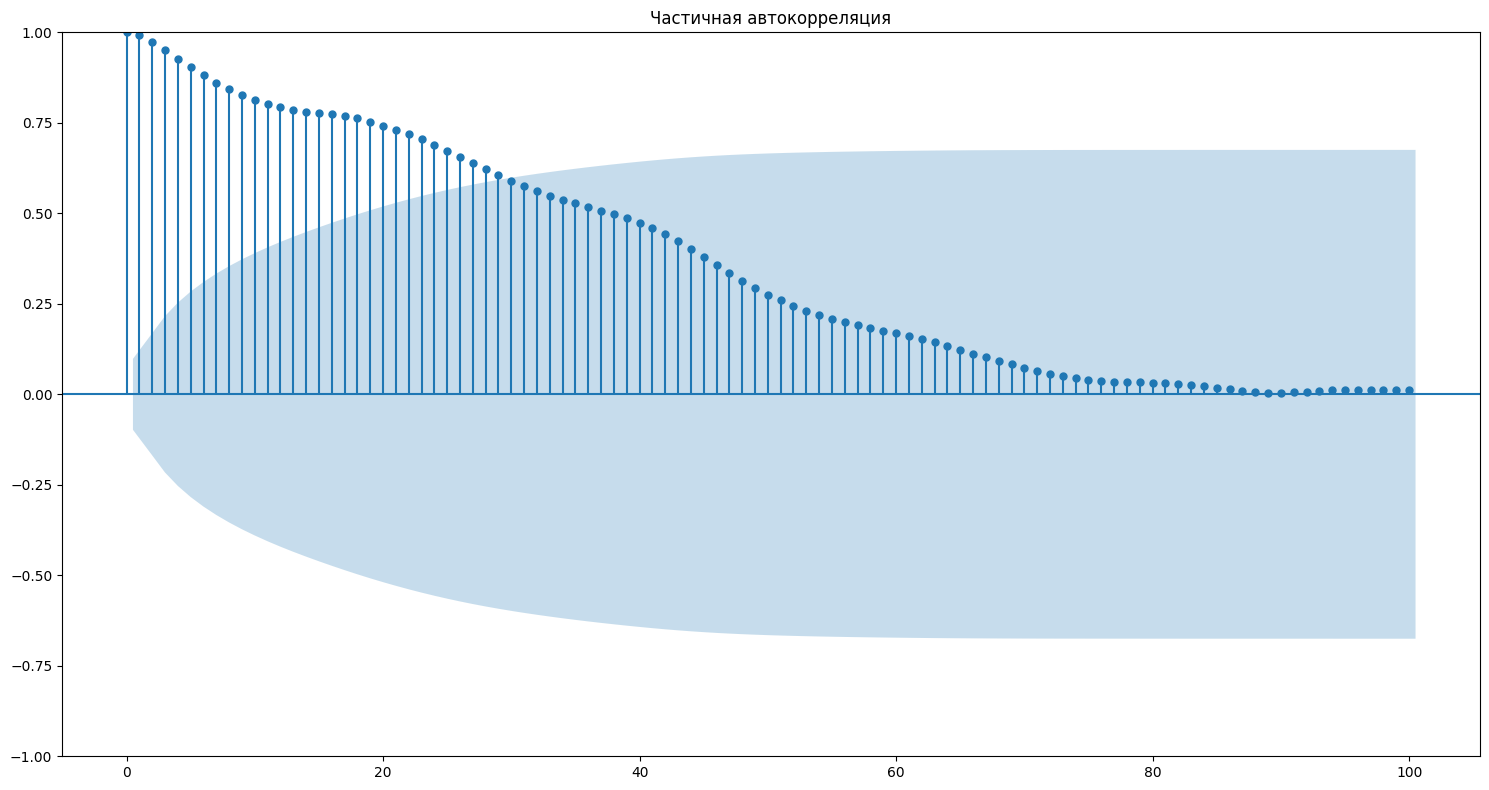

In [194]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15,8))
plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Автокорреляция')

plt.figure(figsize=(15,8))

plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

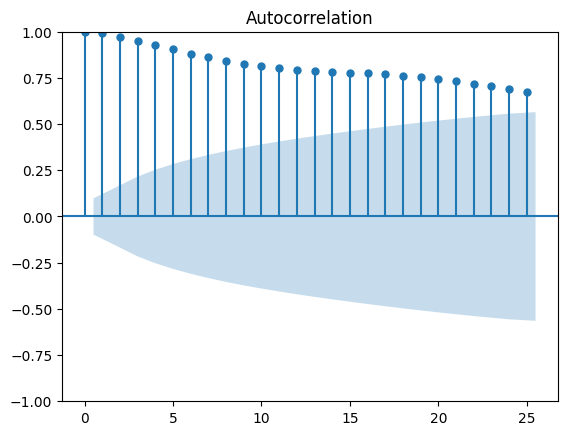

In [195]:
plot_acf(df, lags=25)
plt.show()

In [196]:
from statsmodels.tsa.seasonal import STL

values = np.sin(np.linspace(0, 40, 400)) * 10 + np.arange(400)
data = pd.Series(values, index=df['Цена на арматуру'])

decomposition = STL(df, seasonal=13).fit()
trend = decomposition.trend
seasonal = decomposition.seasonal

In [197]:
df['trend'] = trend
df['season'] = seasonal

In [198]:
df

,Цена на арматуру,trend,season
dt,,,
2015-01-05,32900,28235.519897,503.463837
2015-01-12,32500,28121.129965,273.620016
2015-01-19,32000,28008.849384,-24.582049
2015-01-26,30700,27898.732636,-783.849156
2015-02-02,30300,27790.823509,-1202.269916
...,...,...,...
2022-08-01,47500,51358.329263,-815.929271
2022-08-08,49000,50964.003457,-1517.969954
2022-08-15,47500,50566.857249,-2630.868419


# Работа с выбросами

<Axes: >

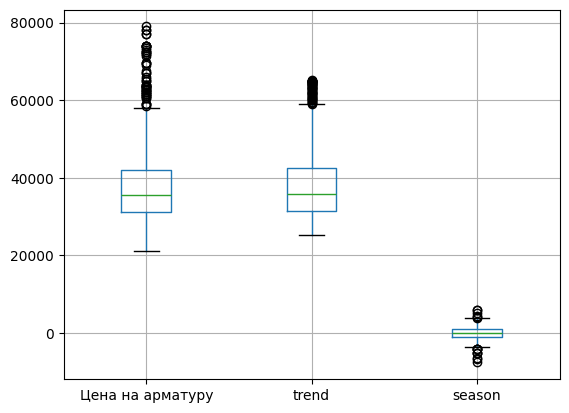

In [199]:
df.boxplot()

# Замена выбросов



Данных очень мало. Так что просто удалить выбросы было бы слишком затратно

Поэтому, можно поробовать сгладить или заменить выбросы с помощью линейной интерполяции или скользящего среднего

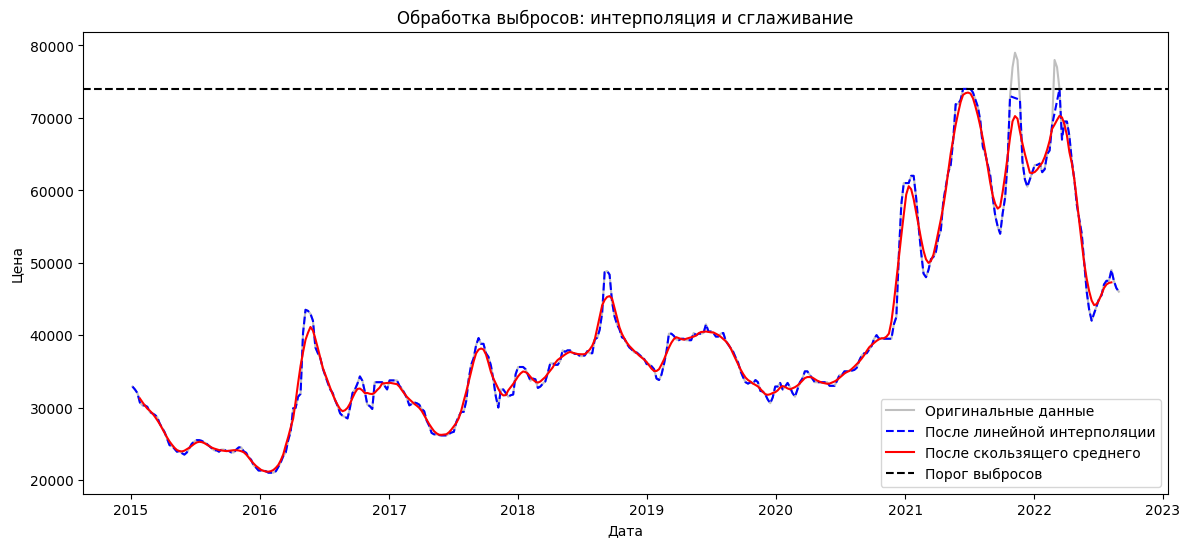

In [200]:

threshold = 74000
outliers = df['Цена на арматуру'] > threshold

df['Цена_Clean'] = df['Цена на арматуру'].copy()
df.loc[outliers, 'Цена_Clean'] = np.nan
df['Цена_Clean'] = df['Цена_Clean'].interpolate(method='linear')


df['Цена_Smooth'] = df['Цена_Clean'].rolling(window=7, center=True).mean()

plt.figure(figsize=(14, 6))

plt.plot(df.index, df['Цена на арматуру'], label="Оригинальные данные", alpha=0.5, color="gray")
plt.plot(df.index, df["Цена_Clean"], label="После линейной интерполяции", linestyle="--", color="blue")
plt.plot(df.index, df["Цена_Smooth"], label="После скользящего среднего", linestyle="-", color="red")

plt.axhline(y=threshold, color="black", linestyle="--", label="Порог выбросов")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Обработка выбросов: интерполяция и сглаживание")
plt.show()

Лучше всего справилась линейная интерполяция, т.к выбросов не осталось и пропущенных значений тоже

<Axes: >

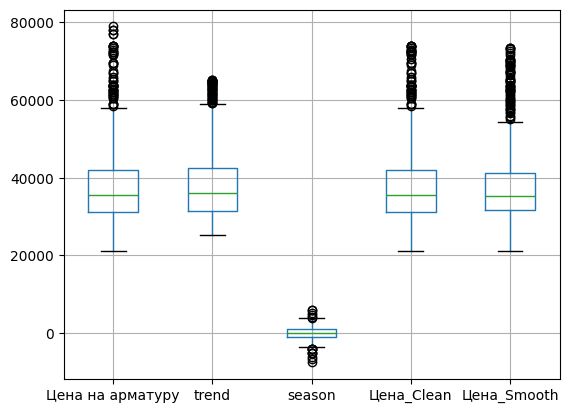

In [201]:
df.boxplot()

Колонки, которые были преобразованы с помощью линейной интерполяции и скользящего среднего, можно использовать как признаки для обучения модели, и давать в качестве Y оригинальные цены

In [202]:
df

,Цена на арматуру,trend,season,Цена_Clean,Цена_Smooth
dt,,,,,
2015-01-05,32900,28235.519897,503.463837,32900.0,NaN
2015-01-12,32500,28121.129965,273.620016,32500.0,NaN
2015-01-19,32000,28008.849384,-24.582049,32000.0,NaN
2015-01-26,30700,27898.732636,-783.849156,30700.0,31257.142857
2015-02-02,30300,27790.823509,-1202.269916,30300.0,30757.142857
...,...,...,...,...,...
2022-08-01,47500,51358.329263,-815.929271,47500.0,47214.285714
2022-08-08,49000,50964.003457,-1517.969954,49000.0,47285.714286
2022-08-15,47500,50566.857249,-2630.868419,47500.0,NaN


# Преобразование временного ряда в стационарный

Надо сделать стационарный временной ряд, и использовать его как признак при обучении модели


Дифференцирование

In [203]:
df['Цена_dif_1'] = df['Цена_Clean'].diff(1)
df['Цена_dif_2'] = df['Цена_Clean'].diff(2)

Логарифмирование

In [204]:
df['Цена_log'] = np.log(df['Цена_Clean'])

Преобразование Бокса-Кокса

In [205]:
from scipy.stats import boxcox

df['Цена_BoxCox'], lambda_bc = boxcox(df['Цена_Clean'] + 1)
print(f'Оптимальный λ: {lambda_bc}')

Оптимальный λ: -0.7092954629514054


In [206]:
df

,Цена на арматуру,trend,season,Цена_Clean,Цена_Smooth,Цена_dif_1,Цена_dif_2,Цена_log,Цена_BoxCox
dt,,,,,,,,,
2015-01-05,32900,28235.519897,503.463837,32900.0,NaN,NaN,NaN,10.401228,1.408968
2015-01-12,32500,28121.129965,273.620016,32500.0,NaN,-400.0,NaN,10.388995,1.408961
2015-01-19,32000,28008.849384,-24.582049,32000.0,NaN,-500.0,-900.0,10.373491,1.408951
2015-01-26,30700,27898.732636,-783.849156,30700.0,31257.142857,-1300.0,-1800.0,10.332018,1.408924
2015-02-02,30300,27790.823509,-1202.269916,30300.0,30757.142857,-400.0,-1700.0,10.318903,1.408915
...,...,...,...,...,...,...,...,...,...
2022-08-01,47500,51358.329263,-815.929271,47500.0,47214.285714,0.0,500.0,10.768485,1.409170
2022-08-08,49000,50964.003457,-1517.969954,49000.0,47285.714286,1500.0,1500.0,10.799576,1.409185
2022-08-15,47500,50566.857249,-2630.868419,47500.0,NaN,-1500.0,0.0,10.768485,1.409170


Экспоненциальное сглаживание

In [207]:
alpha = 0.4

exp_smoothing = [df['Цена на арматуру'].iloc[0]]

for i in range(1, len(df['Цена на арматуру'])):
  exp_smoothing.append(alpha*df['Цена на арматуру'].iloc[i] + (1-alpha)*exp_smoothing[i-1])

print(exp_smoothing[-2])

47182.1182616193


In [208]:
df['exp_smoothing'] = exp_smoothing


Авторегрессия

In [209]:
from statsmodels.tsa.ar_model import AutoReg

auto_reg_model = AutoReg(df['Цена на арматуру'], lags=[1, 2, 3, 4]).fit()

df['Цена_AR'] = auto_reg_model.fittedvalues

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Лаги

In [210]:
for lag in range(1, 6):
  df[f'lag_{lag}'] = df['Цена на арматуру'].shift(lag)

Временные признаки

In [211]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day         # день месяца (1-31)
df['weekofyear'] = df.index.isocalendar().week  # номер недели в году (1-52)
df['dayofweek'] = df.index.dayofweek  # день недели (0 = Пн, 6 = Вс)
df['quarter'] = df.index.quarter  # квартал (1-4)

<Axes: ylabel='dt'>

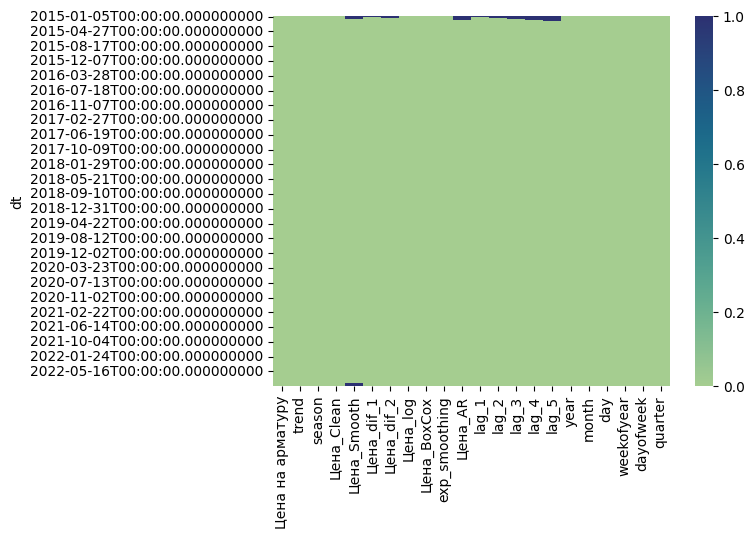

In [212]:
sns.heatmap(df.isnull(), cmap='crest')

In [213]:
df['Цена_Smooth'].values

array([           nan,            nan,            nan, 31257.14285714,
       30757.14285714, 30285.71428571, 29857.14285714, 29571.42857143,
       29214.28571429, 28771.42857143, 28271.42857143, 27742.85714286,
       27114.28571429, 26500.        , 25871.42857143, 25314.28571429,
       24857.14285714, 24442.85714286, 24128.57142857, 23985.71428571,
       23942.85714286, 24042.85714286, 24242.85714286, 24457.14285714,
       24714.28571429, 24985.71428571, 25185.71428571, 25271.42857143,
       25228.57142857, 25100.        , 24900.        , 24700.        ,
       24485.71428571, 24342.85714286, 24228.57142857, 24128.57142857,
       24071.42857143, 24028.57142857, 23985.71428571, 24028.57142857,
       24071.42857143, 24114.28571429, 24107.14285714, 24071.42857143,
       23971.42857143, 23828.57142857, 23514.28571429, 23114.28571429,
       22657.14285714, 22278.57142857, 21928.57142857, 21657.14285714,
       21400.        , 21257.14285714, 21157.14285714, 21142.85714286,
      

# Добавляем цены на сырье

In [214]:
df_raw_material_price = pd.read_excel('/content/drive/MyDrive/ML_3/Цены на сырье.xlsx')

df_raw_material_price.head()

,dt,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т",...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
0,2015-02-09,3850,228,12344,10009,12728,62,NaN,3700.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-16,3850,206,12271,10432,12852,63,NaN,3700.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-02-23,3850,207,12645,11981,13034,64,NaN,3700.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-03-02,3850,214,12696,11912,12910,63,NaN,3700.0,72.0,...,NaN,NaN,3540.0,2097.0,1261.0,23.0,NaN,NaN,NaN,NaN
4,2015-03-09,4400,232,12916,12061,12964,61,NaN,4050.0,70.0,...,NaN,NaN,3540.0,2097.0,1261.0,23.0,NaN,NaN,NaN,NaN


In [215]:
df_raw_material_price['dt'] = pd.to_datetime(df_raw_material_price['dt'], format='%m-%d-%Y')

df_raw_material_price = df_raw_material_price.set_index(['dt'])

In [216]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

for column in df_raw_material_price.columns:
  df_raw_material_price[column] = imputer.fit_transform(df_raw_material_price[[column]])


df_raw_material_price

,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т","Лом_3А, РФ CPT авто Центральный ФО, руб./т, без НДС",...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
dt,,,,,,,,,,,,,,,,,,,,,
2015-02-09,3850.0,228.0,12344.0,10009.0,12728.0,62.0,431.336478,3700.0,70.0,22428.225806,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-02-16,3850.0,206.0,12271.0,10432.0,12852.0,63.0,431.336478,3700.0,70.0,22428.225806,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-02-23,3850.0,207.0,12645.0,11981.0,13034.0,64.0,431.336478,3700.0,72.0,22428.225806,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-03-02,3850.0,214.0,12696.0,11912.0,12910.0,63.0,431.336478,3700.0,72.0,22428.225806,...,21682.5,418.937107,3540.000000,2097.000000,1261.000000,23.000000,93.523148,133.078704,108.363806,149.309701
2015-03-09,4400.0,232.0,12916.0,12061.0,12964.0,61.0,431.336478,4050.0,70.0,22428.225806,...,21682.5,418.937107,3540.000000,2097.000000,1261.000000,23.000000,93.523148,133.078704,108.363806,149.309701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,9500.0,399.0,25741.0,23774.0,24100.0,124.0,505.000000,7500.0,136.5,22600.000000,...,22765.0,457.500000,5043.000000,4382.000000,2577.000000,50.000000,66.000000,78.000000,116.000000,154.000000
2023-02-20,9500.0,390.0,25837.0,24060.0,24184.0,124.0,500.000000,7500.0,137.5,22550.000000,...,23414.0,465.000000,5043.000000,4382.000000,2577.000000,50.000000,66.000000,78.000000,116.000000,154.000000
2023-02-27,9500.0,411.0,25814.0,24275.0,24047.0,130.0,502.500000,7500.0,143.0,22400.000000,...,24014.0,455.000000,5547.000000,4898.000000,2921.000000,56.000000,74.000000,85.000000,122.000000,159.000000


In [217]:
merged_df = df.join(df_raw_material_price, how='outer')

merged_df

,Цена на арматуру,trend,season,Цена_Clean,Цена_Smooth,Цена_dif_1,Цена_dif_2,Цена_log,Цена_BoxCox,exp_smoothing,...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-05,32900.0,28235.519897,503.463837,32900.0,NaN,NaN,NaN,10.401228,1.408968,32900.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-12,32500.0,28121.129965,273.620016,32500.0,NaN,-400.0,NaN,10.388995,1.408961,32740.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-19,32000.0,28008.849384,-24.582049,32000.0,NaN,-500.0,-900.0,10.373491,1.408951,32444.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-26,30700.0,27898.732636,-783.849156,30700.0,31257.142857,-1300.0,-1800.0,10.332018,1.408924,31746.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-02,30300.0,27790.823509,-1202.269916,30300.0,30757.142857,-400.0,-1700.0,10.318903,1.408915,31167.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22765.0,457.5,5043.0,4382.0,2577.0,50.0,66.0,78.0,116.0,154.0
2023-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23414.0,465.0,5043.0,4382.0,2577.0,50.0,66.0,78.0,116.0,154.0
2023-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24014.0,455.0,5547.0,4898.0,2921.0,56.0,74.0,85.0,122.0,159.0


In [218]:
imputer = KNNImputer(n_neighbors=2)


merged_df['Цена на арматуру'] = imputer.fit_transform(merged_df[['Цена на арматуру']])

# Разделение на обучающую и тестовую выборку

In [219]:

train_size = int(len(df)*0.7)
train, test = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

print(f"Размер обучающей выборки: {train.shape}")
print(f"Размер тестовой выборки: {test.shape}")

Размер обучающей выборки: (280, 80)
Размер тестовой выборки: (148, 80)


Разделение на тестовую и обучающую с признаками

In [220]:
merged_df.columns

Index(['Цена на арматуру', 'trend', 'season', 'Цена_Clean', 'Цена_Smooth',
       'Цена_dif_1', 'Цена_dif_2', 'Цена_log', 'Цена_BoxCox', 'exp_smoothing',
       'Цена_AR', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'year', 'month',
       'day', 'weekofyear', 'dayofweek', 'quarter',
       'Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС',
       'Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т',
       'Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС',
       'Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС',
       'Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС',
       'ЖРС_Китай Iron ore fines Fe 62%, CFR', 'Чугун_CFR Италия, $/т',
       'Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС',
       'ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т',
       'Лом_3А, РФ CPT авто Центральный ФО, руб./т, без НДС',
       'Лом_3А, РФ CPT авто Уральский ФО, руб./т, без НДС',
       'Лом_HMS 1/2 80:20, FOB США Восток, $/т',
     

In [221]:
features = merged_df.drop(columns=['Цена на арматуру']).columns.tolist()

X_train = train[features]
Y_train = train['Цена на арматуру']
X_test = test[features]
Y_test = test['Цена на арматуру']

Почему-то CatBoost с Numpy не хотят совмещаться:(((((

In [ ]:
!pip install numpy==1.23.5 catboost==1.2

0:	learn: 5641.2003885	test: 23151.7453234	best: 23151.7453234 (0)	total: 5.3ms	remaining: 2.64s
100:	learn: 806.6234093	test: 16601.9976382	best: 16601.9976382 (100)	total: 464ms	remaining: 1.83s
200:	learn: 451.8975536	test: 15188.9452646	best: 15188.9452646 (200)	total: 885ms	remaining: 1.32s
300:	learn: 323.9178874	test: 14649.0091189	best: 14649.0091189 (300)	total: 1.15s	remaining: 760ms
400:	learn: 247.4613256	test: 14528.2618087	best: 14526.5918953 (393)	total: 1.33s	remaining: 330ms
499:	learn: 203.7666104	test: 14479.1258220	best: 14478.9405662 (498)	total: 1.51s	remaining: 0us

bestTest = 14478.94057
bestIteration = 498

Shrink model to first 499 iterations.
MSE: 209639711.8200
RMSE: 14478.9403
R²: -0.1541


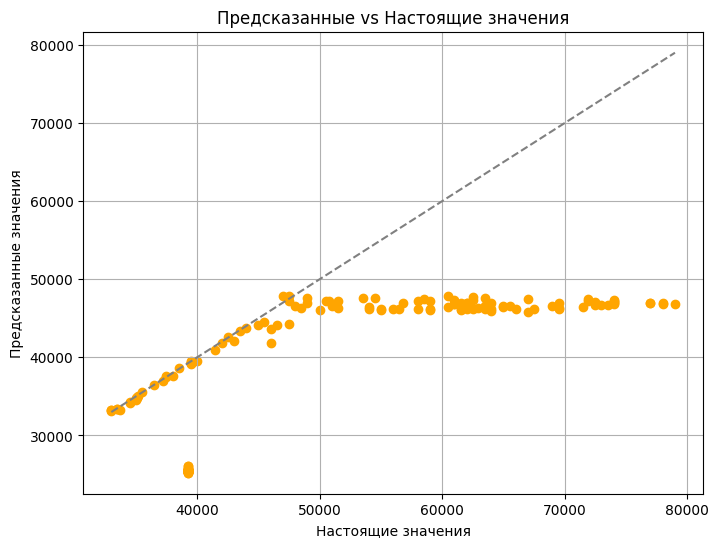

In [222]:

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score




catboost_regressor_model = CatBoostRegressor(
    iterations=500,  # кол.итераций
    learning_rate=0.05,  # скорость обучения
    depth=3,  # глубина деревьев
    l2_leaf_reg=10,  # регулярзация
    eval_metric='RMSE', # метрика
    early_stopping_rounds=50,
    verbose=100
)

catboost_regressor_model.fit(X_train, Y_train, eval_set=(X_test, Y_test))

Y_pred = catboost_regressor_model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
rmse = mse ** 0.5


r2 = r2_score(Y_test, Y_pred)


print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')


plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, color='orange')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], linestyle='--', color='gray')
plt.xlabel('Настоящие значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные vs Настоящие значения')
plt.grid()
plt.show()

In [ ]:
df

,Цена на арматуру,trend,season,Цена_Clean,Цена_Smooth,Цена_dif_1,Цена_dif_2,Цена_log,Цена_BoxCox,exp_smoothing,...,lag_2,lag_3,lag_4,lag_5,year,month,day,weekofyear,dayofweek,quarter
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-05,32900,28235.519897,503.463837,32900.0,NaN,NaN,NaN,10.401228,1.408968,32900.000000,...,NaN,NaN,NaN,NaN,2015,1,5,2,0,1
2015-01-12,32500,28121.129965,273.620016,32500.0,NaN,-400.0,NaN,10.388995,1.408961,32740.000000,...,NaN,NaN,NaN,NaN,2015,1,12,3,0,1
2015-01-19,32000,28008.849384,-24.582049,32000.0,NaN,-500.0,-900.0,10.373491,1.408951,32444.000000,...,32900.0,NaN,NaN,NaN,2015,1,19,4,0,1
2015-01-26,30700,27898.732636,-783.849156,30700.0,31257.142857,-1300.0,-1800.0,10.332018,1.408924,31746.400000,...,32500.0,32900.0,NaN,NaN,2015,1,26,5,0,1
2015-02-02,30300,27790.823509,-1202.269916,30300.0,30757.142857,-400.0,-1700.0,10.318903,1.408915,31167.840000,...,32000.0,32500.0,32900.0,NaN,2015,2,2,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,47500,51358.329263,-815.929271,47500.0,47214.285714,0.0,500.0,10.768485,1.409170,46880.177137,...,47000.0,45500.0,45000.0,44000.0,2022,8,1,31,0,3
2022-08-08,49000,50964.003457,-1517.969954,49000.0,47285.714286,1500.0,1500.0,10.799576,1.409185,47728.106282,...,47500.0,47000.0,45500.0,45000.0,2022,8,8,32,0,3
2022-08-15,47500,50566.857249,-2630.868419,47500.0,NaN,-1500.0,0.0,10.768485,1.409170,47636.863769,...,47500.0,47500.0,47000.0,45500.0,2022,8,15,33,0,3


Надо улучшить показатели модели, привести ряд к стационарному виду, возможно избавиться от выбросов и предсказать на сколько там недель закупать арматуру

Поиск лучших параметров для модели

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [3, 5, 7, 10],
    'iterations': [500, 1000]
}

grid_search = GridSearchCV(estimator=catboost_regressor_model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, Y_train, eval_set=(X_test, Y_test))
print(grid_search.best_params_)

0:	learn: 4264.9226357	test: 23673.7980892	best: 23673.7980892 (0)	total: 1.11ms	remaining: 554ms
100:	learn: 2224.6279188	test: 20750.4893417	best: 20750.4893417 (100)	total: 189ms	remaining: 745ms
200:	learn: 1261.7413605	test: 18378.0401817	best: 18378.0401817 (200)	total: 418ms	remaining: 622ms
300:	learn: 780.3961688	test: 16727.3306326	best: 16727.3306326 (300)	total: 594ms	remaining: 393ms
400:	learn: 519.2667889	test: 15699.4833092	best: 15699.4833092 (400)	total: 811ms	remaining: 200ms
499:	learn: 372.5600798	test: 15100.7056731	best: 15100.7056731 (499)	total: 1.02s	remaining: 0us

bestTest = 15100.70567
bestIteration = 499

0:	learn: 6601.8946728	test: 25862.2927335	best: 25862.2927335 (0)	total: 972us	remaining: 485ms
100:	learn: 3133.2959060	test: 21864.7637446	best: 21864.7637446 (100)	total: 321ms	remaining: 1.27s
200:	learn: 1668.6831587	test: 19361.9745604	best: 19361.9745604 (200)	total: 647ms	remaining: 962ms
300:	learn: 999.6124832	test: 17586.5596910	best: 17586.55

Надо посмотреть, какие признаки **самые важные**

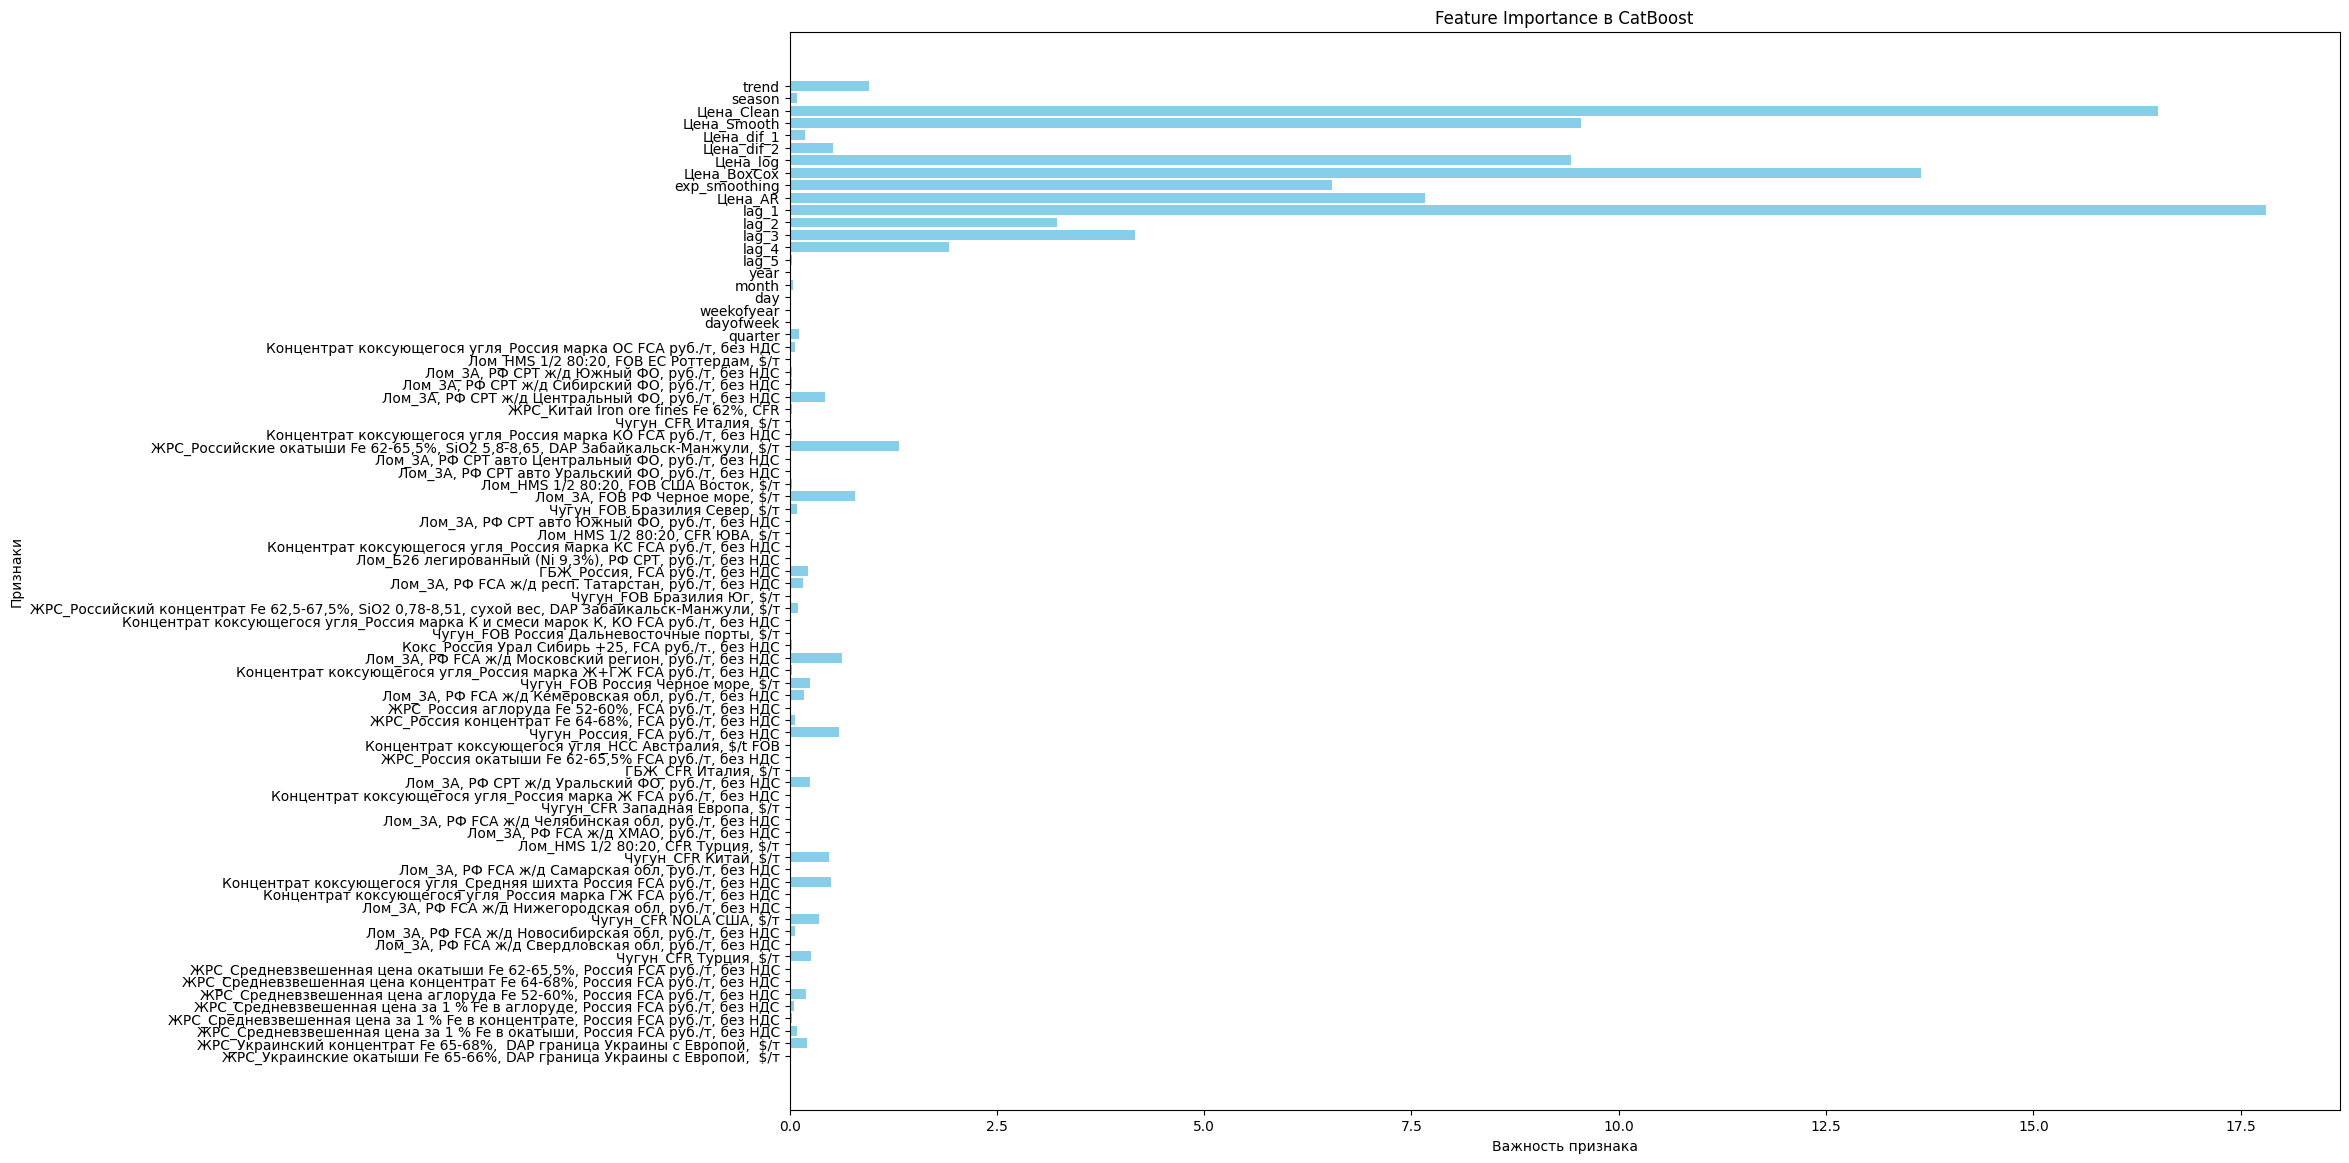

In [224]:
feature_importance = catboost_regressor_model.get_feature_importance()
feature_names = X_train.columns


plt.figure(figsize=(20, 14))
plt.barh(feature_names, feature_importance, color='skyblue')
plt.xlabel("Важность признака")
plt.ylabel("Признаки")
plt.title("Feature Importance в CatBoost")
plt.gca().invert_yaxis()
plt.show()